# 目的

Canon Log3 の OETF、EOTF の理論式を検証する。

# 背景

[Colour Science for Python](http://colour.readthedocs.io/en/latest/index.html) という Pythonモジュールのソースコードを読んでいたら、
Canon Log2/Canon Log3 の OETF/EOTF の数式があった。

Canon Log2/Canon Log3 の数式は一般には公開されていないため、合っていのならパクって使いたい。

そのために本当に正しい数式なのか検証する。

# 手順

1. [このページ](http://colour.readthedocs.io/en/latest/_modules/colour/models/rgb/transfer_functions/canon_log.html?highlight=canon)の数式を使って EOTF を算出
2. [このページ](http://cweb.canon.jp/pls/webcc/WC_SHOW_CONTENTS.EdtDsp?i_cd_pr_catg=139&i_tx_contents_dir=/e-support/faq/answer/cinema/&i_tx_contents_file=67565-1.html&i_fl_edit=1&i_tx_search_pr_name=&i_cd_qasearch=Q000067565)からダウンロードできる公式のLUT値と比較して合致してるか判断
3. OETF式を算出し 横軸を STOPS、縦軸を Code Value のグラフをプロットし[このホワイトペーパー](http://learn.usa.canon.com/app/pdfs/white_papers/Deep-Dive-HDR-Part2.pdf)と一致するか確認

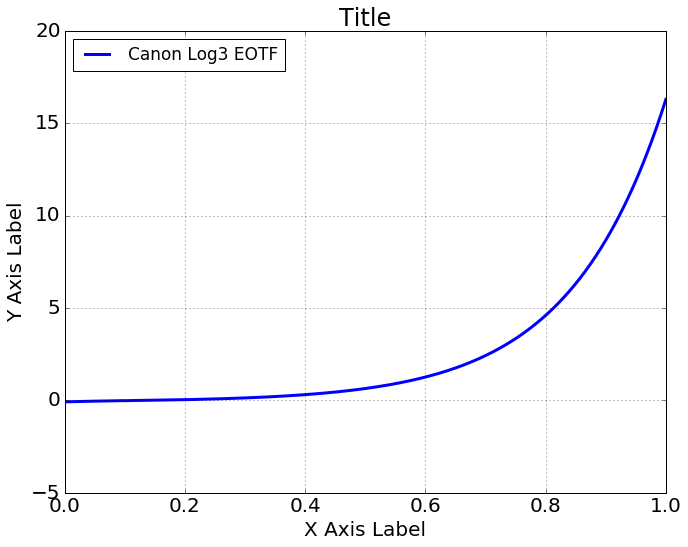

array([ -0.07703262,  -0.07615419,  -0.07528113, ...,  16.09875117,
        16.1981261 ,  16.29811192])

In [4]:
# EOTF算出
# -------------
%matplotlib inline
import gamma_curve as gc
import numpy as np
x = np.linspace(0, 1, 1024)
gc.canon_log3_eotf(x, plot=True)

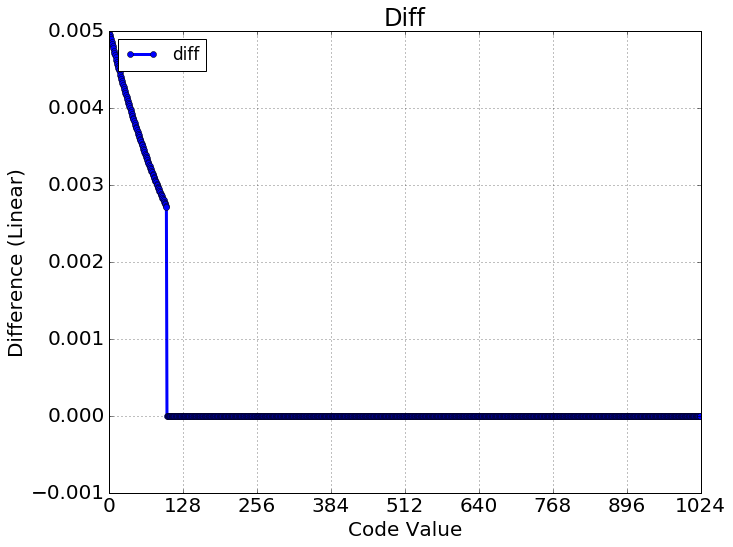

In [9]:
# 公式LUTと値比較
# --------------------
%matplotlib inline
import gamma_curve as gc
import numpy as np
import imp
imp.reload(gc)
x = np.linspace(0, 1, 1024)
y = gc.canon_log3_eotf(x, plot=False)
lut = gc.get_1dlut_from_cube_format("./data/cl3.cube")
gc.plot_diff(y, lut)

なぜか低階調で誤差が大きくなっている。
横軸をIRE値に変えてプロットすると以下。

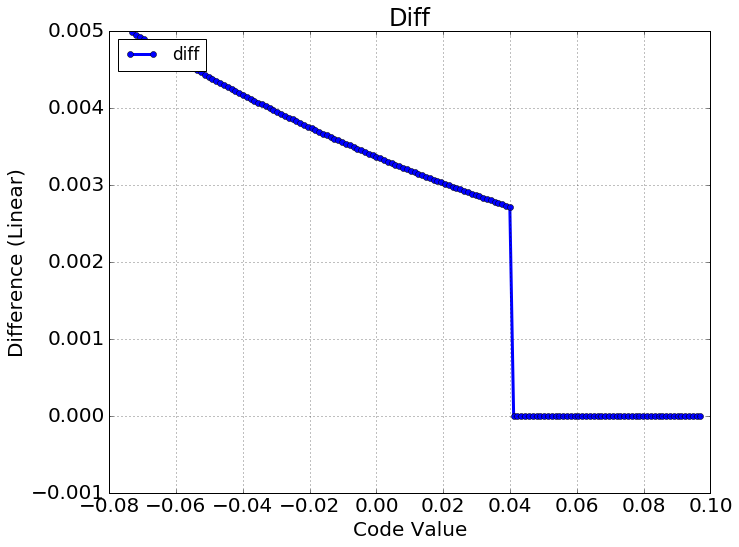

In [15]:
# 横軸を IRE値に変えてプロット
# --------------------
%matplotlib inline
import gamma_curve as gc
import numpy as np
import imp
imp.reload(gc)
x = np.linspace(0, 1, 1024)
y = gc.canon_log3_eotf(x, plot=False)
lut = gc.get_1dlut_from_cube_format("./data/cl3.cube")
gc.plot_diff(y, lut)

これを見ると、ire=0.04 付近で値がおかしくなっている。

ここで、EOTFの式を見ると以下の分岐がある。

```
    y = np.select(
        (ire < 0.04076162, ire <= 0.105357102,
         ire > 0.105357102),
        (-(10 ** ((0.069886632 - ire) / 0.42889912) - 1) / 14.98325,
         (ire - 0.073059361) / 2.3069815,
         (10 ** ((ire - 0.069886632) / 0.42889912) - 1) / 14.98325))
```

これを踏まえると考えられる原因は２つ。

1. 上記式の `ire < 0.04076162` の計算式に誤りがある
2. 俺のカスタマイズで *code_value to ire* の処理が入っているが、そこに誤りがある

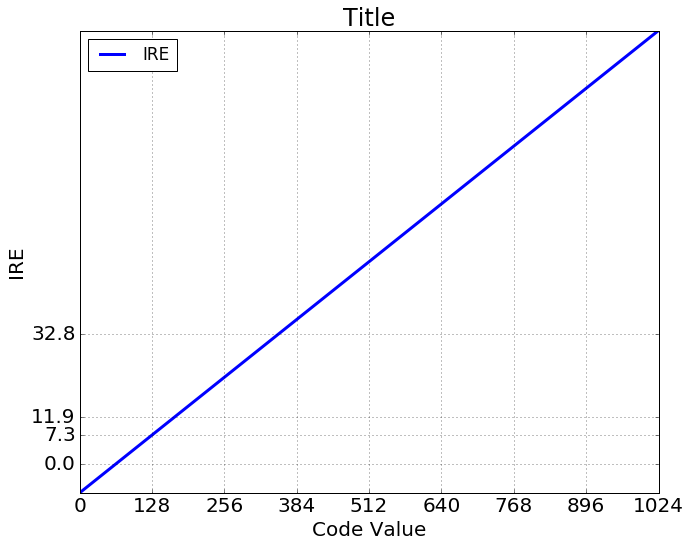

In [31]:
# Code Value to IRE transform
# --------------------------------
import plot_utility as pu
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1024)
ire = (x * 1023 - 64) / (940 - 64)

ax1 = pu.plot_1_graph(fontsize=20,
                      figsize=(10, 8),
                      graph_title="Title",
                      graph_title_size=None,
                      xlabel="Code Value", ylabel="IRE",
                      axis_label_size=None,
                      legend_size=17,
                      xlim=(0, 1024),
                      ylim=None,
                      xtick=[x * 128 for x in range(1024//128+1)],
                      ytick=[0, 7.3, 11.9, 32.8, ],
                      xtick_size=None, ytick_size=None,
                      linewidth=3)
ax1.plot(x * 1023, ire*100, label="IRE")
plt.legend(loc='upper left')
plt.show()

# よくわかりません！

とりあえず低階調のミスの追求はあきらめます。

続いて、OETFの実装です。


# OETF の実装と確認

いつも通り、OETF --> EOTF を通してデータが直線になることを確認する。

C:\home\sip\matplotlib\gamma_curve\gamma_curve.py:58: RuntimeWarning: invalid value encountered in log10
  (-(0.42889912 * (np.log10(-x * 14.98325 + 1)) - 0.069886632),


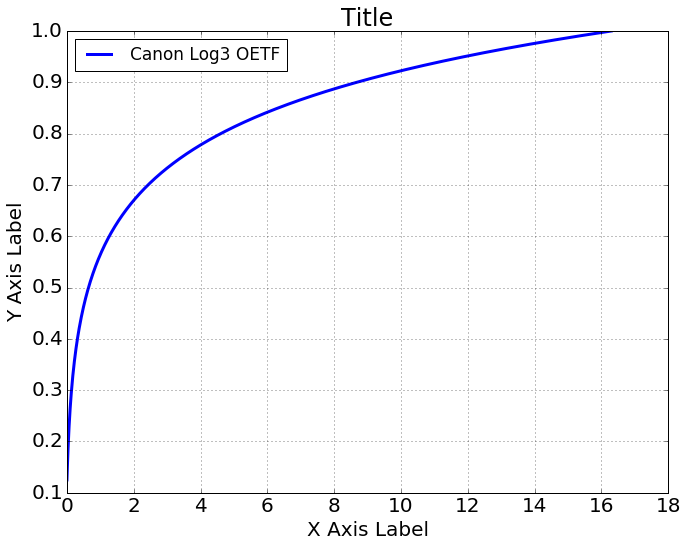

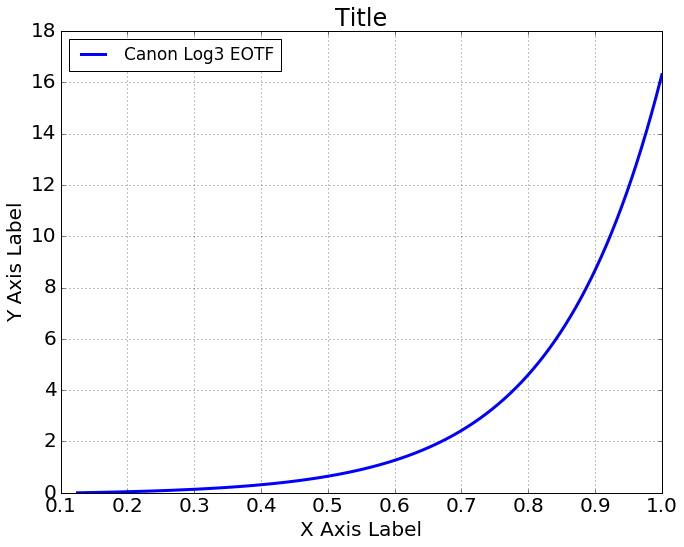

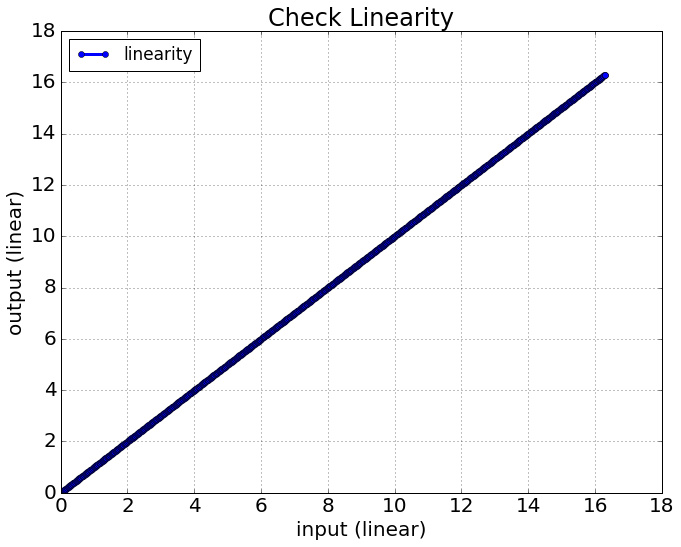

In [36]:
%matplotlib inline
import gamma_curve as gc
import numpy as np
import imp
imp.reload(gc)

x = np.linspace(0, 1, 1024)
max_val = gc.canon_log3_eotf(1.0, plot=False)
clog3 = gc.canon_log3_oetf(x * max_val, plot=True)
linear = gc.canon_log3_eotf(clog3, plot=True)
ax1 = pu.plot_1_graph(fontsize=20,
                      figsize=(10, 8),
                      graph_title="Check Linearity",
                      graph_title_size=None,
                      xlabel="input (linear)", ylabel="output (linear)",
                      axis_label_size=None,
                      legend_size=17,
                      xlim=None,
                      ylim=None,
                      xtick=None,
                      ytick=None,
                      xtick_size=None, ytick_size=None,
                      linewidth=3)
ax1.plot(x * max_val, linear, '-o', label="linearity")
plt.legend(loc='upper left')
plt.show()

# 横軸を対数かつ18%中心のグラフを書く